# K-Nearest Neighbors (KNN): Background, Definition, and Key Formulas

## Background (intuition)
**K-Nearest Neighbors (KNN)** is one of the simplest machine learning methods.  
It is called **non-parametric** because it does not learn a fixed set of parameters (like weights in linear regression).  
Instead, it **stores the training data** and makes predictions for a new point by looking at the **closest training examples**.

KNN follows the idea:
> “Points that are close to each other in feature space tend to have similar labels/values.”

Because of this, KNN is often used to introduce:
- the concept of **distance in data space**
- the meaning of **local neighborhoods**
- the tradeoff between **overfitting vs. smoothing** controlled by the choice of $k$

---

## Setup and notation
Let the training set be
$$
\{(x_i, y_i)\}_{i=1}^n,
$$
where:
- $x_i \in \mathbb{R}^d$ is a feature vector (a point in $d$-dimensional space),
- $y_i$ is the target:
  - for **classification**: $y_i \in \{1,2,\dots,C\}$,
  - for **regression**: $y_i \in \mathbb{R}$.

Given a new input point $x \in \mathbb{R}^d$, KNN uses the training points nearest to $x$.

---

## Distance (most common choice)
The most common distance is **Euclidean distance**:
$$
d(x, x_i) = \|x - x_i\|_2 = \sqrt{\sum_{j=1}^d (x_j - x_{i,j})^2}.
$$

Other distances can also be used (depending on the problem), such as:
- Manhattan distance: $\|x-x_i\|_1 = \sum_{j=1}^d |x_j - x_{i,j}|$
- Minkowski distance (general family)
- Cosine distance (common for text/embeddings)

---

## The k-nearest neighbor set
Define $N_k(x)$ to be the **set of indices** of the $k$ training points closest to $x$:
$$
N_k(x) = \{ i \in \{1,\dots,n\} : x_i \text{ is among the } k \text{ closest points to } x \}.
$$

---

## KNN for classification (majority vote)
For classification, KNN predicts the class that appears most often among the neighbors:
$$
\hat{y}(x) = \arg\max_{c \in \{1,\dots,C\}} \sum_{i \in N_k(x)} \mathbf{1}(y_i = c),
$$
where $\mathbf{1}(\cdot)$ is the indicator function (1 if true, 0 otherwise).

### Estimated class probabilities (optional)
KNN can also estimate the probability of each class:
$$
\hat{P}(Y=c \mid X=x) = \frac{1}{k} \sum_{i \in N_k(x)} \mathbf{1}(y_i = c).
$$

---

## KNN for regression (average of neighbors)
For regression, KNN predicts the **mean** of the neighbor targets:
$$
\hat{y}(x) = \frac{1}{k} \sum_{i \in N_k(x)} y_i.
$$

---

## Weighted KNN (optional extension)
Sometimes closer neighbors should matter more. A common approach is **distance weighting**:
$$
w_i(x) = \frac{1}{d(x,x_i) + \varepsilon},
$$
where $\varepsilon > 0$ prevents division by zero.

### Weighted regression
$$
\hat{y}(x) = \frac{\sum_{i \in N_k(x)} w_i(x)\, y_i}{\sum_{i \in N_k(x)} w_i(x)}.
$$

### Weighted classification
$$
\hat{y}(x) = \arg\max_{c} \sum_{i \in N_k(x)} w_i(x)\, \mathbf{1}(y_i=c).
$$

---

## Choosing $k$: what it changes
- **Small $k** (like $k=1$ or $k=3$):
  - very flexible decision boundary
  - can overfit (sensitive to noise)
- **Large $k**:
  - smoother boundary
  - can underfit (too much averaging)

A common practice is to choose $k$ using **validation** (try several values and pick the best).

---

## Practical notes
- KNN is sensitive to feature scale, so we often **standardize** features:
  $$
  x_j \leftarrow \frac{x_j - \mu_j}{\sigma_j}.
  $$
- Prediction time can be slow for large datasets because KNN compares a query point to many training points.
- Despite its simplicity, KNN can work surprisingly well as a baseline.


## Problem 4 — K-Nearest Neighbors (12 points)

Consider the following dataset with **nine** points for a **binary classification** task ($y \in \{+,-\}$) with a **scalar feature** $x$.

**Tie-breaking rule:** In case of ties (equal votes), **prefer the negative class** ($-$).  
Put final answers in the box.

### Dataset (1D points)

| Point | $x$  | $y$ |
|------:|:----:|:---:|
| 1 | 0.5 | $+$ |
| 2 | 1.3 | $-$ |
| 3 | 2.3 | $-$ |
| 4 | 3.0 | $-$ |
| 5 | 5.1 | $+$ |
| 6 | 6.5 | $-$ |
| 7 | 8.0 | $+$ |
| 8 | 9.0 | $+$ |
| 9 | 9.5 | $-$ |

---

### Questions

1. **Compute the training error of a 1-nearest neighbor (1-NN) classifier.** (3 points)

2. **Compute the leave-one-out cross-validation (LOOCV) error of a 1-nearest neighbor (1-NN) classifier.** (3 points)

3. **Compute the training error of a 2-nearest neighbor (2-NN) classifier.** (3 points)

4. **Compute the leave-one-out cross-validation (LOOCV) error of a 2-nearest neighbor (2-NN) classifier.** (3 points)


KNN test accuracy with k=7: 1.000


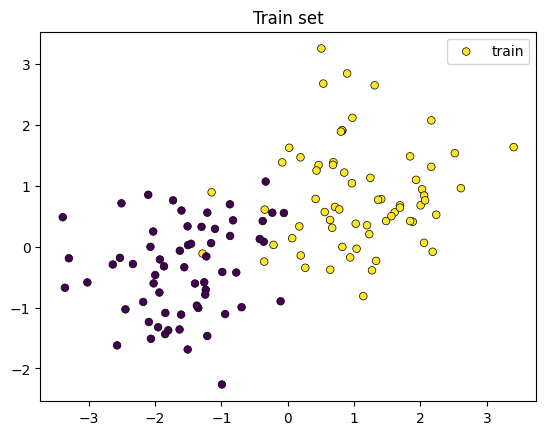

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# 1) Make a simple 2D dataset
# ----------------------------
rng = np.random.default_rng(0)

n_per_class = 80
X0 = rng.normal(loc=[-1.5, -0.5], scale=0.8, size=(n_per_class, 2))
X1 = rng.normal(loc=[ 1.2,  0.8], scale=0.8, size=(n_per_class, 2))

X = np.vstack([X0, X1])
y = np.hstack([np.zeros(n_per_class, dtype=int), np.ones(n_per_class, dtype=int)])

# Shuffle + train/test split
idx = rng.permutation(len(X))
X, y = X[idx], y[idx]
split = int(0.8 * len(X))
X_train, y_train = X[:split], y[:split]
X_test,  y_test  = X[split:], y[split:]


# ----------------------------
# 2) KNN from scratch
# ----------------------------
def knn_predict_one(X_train, y_train, x_query, k=5):
    """
    Predict one label using KNN (classification).
    - Compute distances from x_query to every training point
    - Take k nearest
    - Majority vote
    """
    # Euclidean distances (no sqrt needed for ranking)
    d2 = np.sum((X_train - x_query) ** 2, axis=1)
    nn_idx = np.argsort(d2)[:k]
    nn_labels = y_train[nn_idx]

    # Majority vote (works for labels 0..C-1)
    counts = np.bincount(nn_labels)
    return np.argmax(counts)

def knn_predict(X_train, y_train, X_queries, k=5):
    return np.array([knn_predict_one(X_train, y_train, xq, k) for xq in X_queries])


# ----------------------------
# 3) Evaluate + visualize boundary
# ----------------------------
k = 7
y_pred = knn_predict(X_train, y_train, X_test, k=k)
acc = (y_pred == y_test).mean()
print(f"KNN test accuracy with k={k}: {acc:.3f}")

# Make a grid of points across the plane, classify each one
pad = 0.8
x_min, x_max = X[:, 0].min() - pad, X[:, 0].max() + pad
y_min, y_max = X[:, 1].min() - pad, X[:, 1].max() + pad

grid_res = 220
xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid_res),
                     np.linspace(y_min, y_max, grid_res))
grid_points = np.c_[xx.ravel(), yy.ravel()]

grid_pred = knn_predict(X_train, y_train, grid_points, k=k).reshape(xx.shape)

plt.figure()
#plt.contourf(xx, yy, grid_pred, alpha=0.25)  # decision regions
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, edgecolors="k", linewidths=0.5, label="train")
#plt.scatter(X_test[:, 0],  X_test[:, 1],  c=y_test,  s=70, marker="*", edgecolors="k", linewidths=0.8, label="test")
plt.title(f"Train set")
plt.legend()
plt.show()


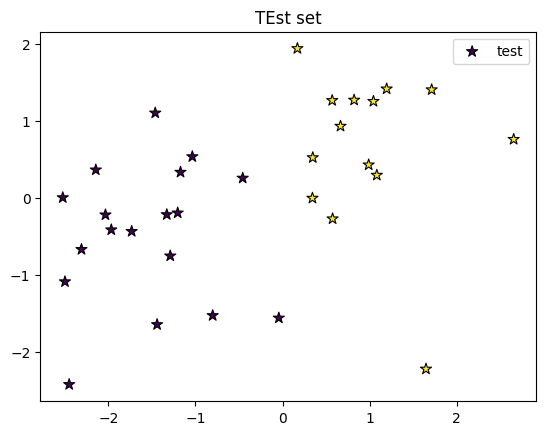

In [13]:
plt.figure()
#plt.contourf(xx, yy, grid_pred, alpha=0.25)  # decision regions
#plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, edgecolors="k", linewidths=0.5, label="train")
plt.scatter(X_test[:, 0],  X_test[:, 1],  c=y_test,  s=70, marker="*", edgecolors="k", linewidths=0.8, label="test")
plt.title(f"TEst set")
plt.legend()
plt.show()

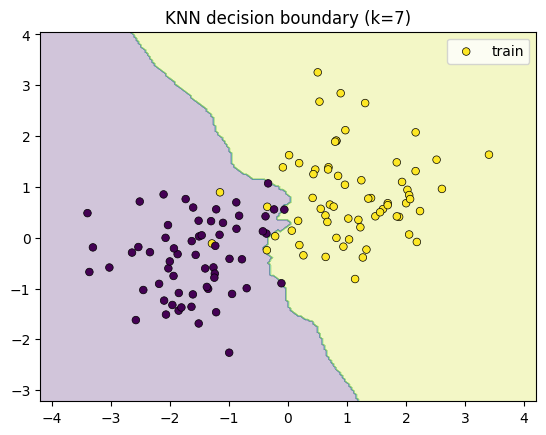

In [5]:
plt.figure()
plt.contourf(xx, yy, grid_pred, alpha=0.25)  # decision regions
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, edgecolors="k", linewidths=0.5, label="train")
#plt.scatter(X_test[:, 0],  X_test[:, 1],  c=y_test,  s=70, marker="*", edgecolors="k", linewidths=0.8, label="test")
plt.title(f"KNN decision boundary (k={k})")
plt.legend()
plt.show()

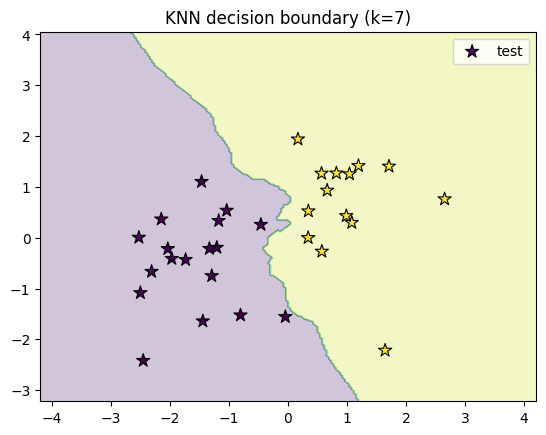

In [11]:

plt.figure()
plt.contourf(xx, yy, grid_pred, alpha=0.25)  # decision regions
#plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, edgecolors="k", linewidths=0.5, label="train")
plt.scatter(X_test[:, 0],  X_test[:, 1],  c=y_test,  s=100, marker="*", edgecolors="k", linewidths=0.8, label="test")
plt.title(f"KNN decision boundary (k={k})")
plt.legend()
plt.show()
